### Imports and Setup

In [ ]:
!pip install scipy

In [ ]:
!pip install datasets

In [ ]:
!pip install textstat

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.1/105.1 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 31.7 MB/s eta 0:00:00


In [ ]:
!pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 36.3 MB/s eta 0:00:00


In [ ]:
!pip install spacy textblob

In [ ]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 17.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=31b7104c23720866eaa99ec08d5b049e4529a945792df53d86ee2a53c8ed71f8
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [ ]:
!pip install openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 361.2/361.2 kB 24.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.9/318.9 kB 25.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 3.9 MB/s eta 0:00:00


In [100]:
import re
from collections import Counter
import warnings
import numpy as np
import pandas as pd
from collections import deque
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from transformers import get_linear_schedule_with_warmup
from sklearn.tree import DecisionTreeClassifier, plot_tree
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from torch.utils.data import DataLoader, Dataset, TensorDataset, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import GPT2Tokenizer, GPT2ForSequenceClassification
from lime.lime_text import LimeTextExplainer
from lime.lime_tabular import LimeTabularExplainer
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from tqdm import tqdm
import time
import logging
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from textstat import flesch_reading_ease, gunning_fog
import spacy
from textblob import TextBlob
from scipy.stats import entropy
import openai

nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)


warnings.filterwarnings("ignore", category=RuntimeWarning)

In [101]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [102]:
%cd /content/drive/MyDrive/

/content/drive/MyDrive


In [ ]:
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA is available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.3.1+cu121
CUDA is available: True
CUDA device: NVIDIA A100-SXM4-40GB


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


### Exploratory Data Analysis

In [ ]:
def perform_eda(df):
    print("Exploratory Data Analysis")
    print("=" * 30)

    # 1. Basic dataset information
    print("\n1. Dataset Information:")
    print(f"Total number of samples: {len(df)}")
    print(f"Number of human-written texts: {sum(df['label'] == 0)}")
    print(f"Number of machine-generated texts: {sum(df['label'] == 1)}")

    # 2. Text length analysis
    df['text_length'] = df['text'].apply(len)

    plt.figure(figsize=(10, 6))
    sns.histplot(data=df, x='text_length', hue='label', multiple='stack', bins=50)
    plt.title('Distribution of Text Lengths')
    plt.xlabel('Text Length')
    plt.ylabel('Count')
    plt.legend(['Human', 'Machine'])
    plt.show()

    print("\n2. Text Length Statistics:")
    print(df.groupby('label')['text_length'].describe())

    # 3. Word count analysis
    df['word_count'] = df['text'].apply(lambda x: len(x.split()))

    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df, x='label', y='word_count')
    plt.title('Word Count Distribution by Label')
    plt.xlabel('Label (0: Human, 1: Machine)')
    plt.ylabel('Word Count')
    plt.show()

    # 4. Most common words
    def get_top_words(texts, n=20):
        words = ' '.join(texts).lower().split()
        return Counter(words).most_common(n)

    human_top_words = get_top_words(df[df['label'] == 0]['text'])
    machine_top_words = get_top_words(df[df['label'] == 1]['text'])

    print("\n4. Top 20 words in human-written texts:")
    print(human_top_words)
    print("\nTop 20 words in machine-generated texts:")
    print(machine_top_words)

    # 5. Word clouds
    def create_wordcloud(text):
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.show()

    print("\n5. Word Clouds:")
    print("Human-written texts:")
    create_wordcloud(' '.join(df[df['label'] == 0]['text']))
    print("Machine-generated texts:")
    create_wordcloud(' '.join(df[df['label'] == 1]['text']))

    # 6. Sentiment analysis
    if 'sentiment_score' not in df.columns:
        from textblob import TextBlob
        df['sentiment_score'] = df['text'].apply(lambda x: TextBlob(x).sentiment.polarity)

    plt.figure(figsize=(10, 6))
    sns.violinplot(data=df, x='label', y='sentiment_score')
    plt.title('Sentiment Distribution by Label')
    plt.xlabel('Label (0: Human, 1: Machine)')
    plt.ylabel('Sentiment Score')
    plt.show()

    print("\n6. Sentiment Analysis:")
    print(df.groupby('label')['sentiment_score'].describe())

    # 7. Readability analysis
    if 'readability_score' not in df.columns:
        from textstat import flesch_reading_ease
        df['readability_score'] = df['text'].apply(flesch_reading_ease)

    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df, x='label', y='readability_score')
    plt.title('Readability Score Distribution by Label')
    plt.xlabel('Label (0: Human, 1: Machine)')
    plt.ylabel('Flesch Reading Ease Score')
    plt.show()

    print("\n7. Readability Analysis:")
    print(df.groupby('label')['readability_score'].describe())


### Data Loading and Preprocessing

In [ ]:
nlp = spacy.load("en_core_web_sm")

In [ ]:
#load datasets
def load_data():
    df_gpt_wiki = pd.read_csv("hf://datasets/aadityaubhat/GPT-wiki-intro/GPT-wiki-intro.csv.zip")
    df_abstracts = pd.read_csv("hf://datasets/NicolaiSivesind/ChatGPT-Research-Abstracts/research_abstracts-final.csv")
    df_essay = pd.read_csv("Training_Essay_Data.csv")

    df_human = pd.concat([
        pd.DataFrame({'text': df_gpt_wiki['wiki_intro']}),
        pd.DataFrame({'text': df_abstracts['real_abstract']}),
        df_essay[df_essay['generated'] == 0][['text']]
    ], ignore_index=True)

    df_generated = pd.concat([
        pd.DataFrame({'text': df_gpt_wiki['generated_text']}),
        pd.DataFrame({'text': df_abstracts['generated_abstract']}),
        df_essay[df_essay['generated'] == 1][['text']]
    ], ignore_index=True)

    df_combined = pd.DataFrame({
        'text': pd.concat([df_human['text'], df_generated['text']]),
        'label': [0] * len(df_human) + [1] * len(df_generated)
    })

    return df_combined

#Preprocess
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    return text

def clean_data(texts, labels):
    cleaned_texts, cleaned_labels = [], []
    for text, label in zip(texts, labels):
        if len(text.strip()) > 10:
            cleaned_texts.append(text)
            cleaned_labels.append(label)
    return cleaned_texts, cleaned_labels

### Feature Extraction

In [ ]:
def extract_cpu_features(text):
    # Basic tokenization
    sentences = sent_tokenize(text)
    words = word_tokenize(text.lower())

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]

    # Basic features
    sentence_lengths = [len(word_tokenize(sent)) for sent in sentences]
    word_lengths = [len(word) for word in words]

    # POS tagging
    pos_tags = nltk.pos_tag(words)
    pos_counts = FreqDist(tag for word, tag in pos_tags)

    # Calculate advanced features
    doc = nlp(text)
    avg_dependency_distance = np.mean([abs(token.i - token.head.i) for token in doc if token.dep_ != 'ROOT'])
    tree_depth = max(len(list(token.ancestors)) for token in doc)
    num_clauses = len([sent for sent in doc.sents if any(token.dep_ == 'ccomp' for token in sent)])
    coreference_density = len([token for token in doc if token.dep_ == 'nsubj' and token.pos_ == 'PRON']) / len(doc)

    # Sentiment analysis
    blob = TextBlob(text)
    sentiment_polarity = blob.sentiment.polarity
    sentiment_subjectivity = blob.sentiment.subjectivity

    # Word entropy
    word_freq = FreqDist(words)
    word_entropy = entropy(list(word_freq.values()))

    features = {
        'avg_sentence_length': np.mean(sentence_lengths) if sentence_lengths else 0,
        'sentence_length_variation': np.std(sentence_lengths) if len(sentence_lengths) > 1 else 0,
        'avg_word_length': np.mean(word_lengths) if word_lengths else 0,
        'word_length_variation': np.std(word_lengths) if len(word_lengths) > 1 else 0,
        'lexical_diversity': len(set(words)) / len(words) if words else 0,
        'pronoun_ratio': pos_counts['PRP'] / len(words) if words else 0,
        'conjunction_ratio': (pos_counts['CC'] + pos_counts['IN']) / len(words) if words else 0,
        'readability_score': flesch_reading_ease(text) if text.strip() else 0,
        'complexity_score': gunning_fog(text) if text.strip() else 0,
        'noun_ratio': pos_counts['NN'] / len(words) if words else 0,
        'verb_ratio': pos_counts['VB'] / len(words) if words else 0,
        'adjective_ratio': pos_counts['JJ'] / len(words) if words else 0,
        'adverb_ratio': pos_counts['RB'] / len(words) if words else 0,
        'word_entropy': word_entropy,
        'avg_dependency_distance': avg_dependency_distance,
        'tree_depth': tree_depth,
        'num_clauses': num_clauses,
        'coreference_density': coreference_density,
        'sentiment_polarity': sentiment_polarity,
        'sentiment_subjectivity': sentiment_subjectivity,
    }

    return list(features.values())


def extract_gpu_features(input_ids, attention_mask, device):
    #GPU features
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)

    # Basic features
    sentence_count = torch.sum(input_ids == tokenizer.sep_token_id, dim=1)
    word_count = torch.sum(attention_mask, dim=1)

    # Lexical diversity
    unique_word_count = torch.tensor([len(torch.unique(ids)) for ids in input_ids], device=device)
    lexical_diversity = unique_word_count.float() / word_count.float()

    return torch.stack([sentence_count, word_count, lexical_diversity], dim=1)

### Content Type Clustering

In [ ]:
def cluster_content_types(all_texts):
    vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
    X = vectorizer.fit_transform(all_texts)

    n_clusters = 4
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(X)

    cluster_to_content = {
        0: "General Knowledge",
        1: "Music and Entertainment",
        2: "Sports and Media",
        3: "Academia and Biographies"
    }

    content_types = [cluster_to_content[cluster] for cluster in clusters]

    def group_content_types(content_type):
        if content_type in ["General Knowledge", "Academia and Biographies"]:
            return "Academic"
        else:
            return "Entertainment"

    grouped_content_types = [group_content_types(ct) for ct in content_types]

    return content_types, grouped_content_types

def analyze_content_distribution(content_types, grouped_content_types):
    content_type_counts = Counter(content_types)
    print("\nDistribution of content types:")
    for content_type, count in content_type_counts.items():
        print(f"{content_type}: {count}")

    grouped_content_type_counts = Counter(grouped_content_types)
    print("\nDistribution of grouped content types:")
    for content_type, count in grouped_content_type_counts.items():
        print(f"{content_type}: {count}")

### Data Preprocessing

In [ ]:
def process_in_batches(texts, labels, tokenizer, batch_size=32, max_length=128, device='cuda'):
    all_input_ids, all_attention_masks, all_advanced_features, all_labels = [], [], [], []

    for i in tqdm(range(0, len(texts), batch_size), desc="Processing batches"):
        try:
            batch_texts = texts[i:i+batch_size]
            batch_labels = labels[i:i+batch_size]

            # CPU feature extraction
            cpu_features = [extract_cpu_features(preprocess_text(text)) for text in batch_texts]

            # Tokenization and GPU operations
            encodings = tokenizer(batch_texts, truncation=True, padding=True, max_length=max_length, return_tensors='pt').to(device)
            gpu_features = extract_gpu_features(encodings['input_ids'], encodings['attention_mask'], device)

            # Combine CPU and GPU features
            cpu_features_tensor = torch.tensor(cpu_features, device=device)
            combined_features = torch.cat([cpu_features_tensor, gpu_features], dim=1)

            # Convert labels to tensor on GPU
            batch_labels_tensor = torch.tensor(batch_labels, dtype=torch.long, device=device)

            # Append tensors to lists
            all_input_ids.append(encodings['input_ids'].cpu())
            all_attention_masks.append(encodings['attention_mask'].cpu())
            all_advanced_features.append(combined_features.cpu())
            all_labels.append(batch_labels_tensor.cpu())

        except Exception as e:
            print(f"Error processing batch {i//batch_size}: {str(e)}")
            print(f"Batch size: {len(batch_texts)}")
            print(f"Input IDs shape: {encodings['input_ids'].shape}")
            print(f"Attention mask shape: {encodings['attention_mask'].shape}")
            print(f"CPU features shape: {len(cpu_features), len(cpu_features[0])}")
            if 'gpu_features' in locals():
                print(f"GPU features shape: {gpu_features.shape}")
            else:
                print("GPU features not computed due to error")
            raise

    #Concatenate all tensors
    return (torch.cat(all_input_ids),
            torch.cat(all_attention_masks),
            torch.cat(all_advanced_features),
            torch.cat(all_labels))

### Baseline Model for Comparison

In [ ]:
openai.api_key = 'your-api-key-here'

def classify_text_gpt3_5(text):
    response = openai.Completion.create(
        model="text-davinci-003",  # This is GPT-3.5's model identifier
        prompt=f"Classify the following text as 'human-written' or 'machine-generated':\n\n{text}",
        max_tokens=10
    )
    classification = response.choices[0].text.strip()
    return classification


### Model Definition

In [ ]:
class FeatureAttention(nn.Module):
    def __init__(self, feature_dim):
        super(FeatureAttention, self).__init__()
        self.attention = nn.Linear(feature_dim, 1)

    def forward(self, features):
        features = features.float()
        attention_weights = F.softmax(self.attention(features), dim=1)
        weighted_features = torch.sum(attention_weights * features, dim=1)
        return weighted_features.unsqueeze(1)

class CustomBERTModel(nn.Module):
    def __init__(self, bert_model, num_linguistic_features):
        super(CustomBERTModel, self).__init__()
        self.bert = bert_model
        self.dropout = nn.Dropout(0.3)
        self.feature_attention = FeatureAttention(num_linguistic_features)

        # Calculate the correct input size for the fusion layer
        fusion_input_size = self.bert.config.hidden_size + 1  # +1 for the weighted linguistic feature

        # Fusion layer
        self.fusion = nn.Linear(fusion_input_size, 512)

        self.classifier = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 2)
        )

    def forward(self, input_ids, attention_mask, linguistic_features):
        # Ensure all inputs are float
        input_ids = input_ids.float()
        attention_mask = attention_mask.float()
        linguistic_features = linguistic_features.float()

        # BERT output
        outputs = self.bert(input_ids=input_ids.long(), attention_mask=attention_mask)  # BERT expects long tensors for input_ids
        pooled_output = outputs.pooler_output
        pooled_output = self.dropout(pooled_output)

        # Apply attention to linguistic features
        weighted_features = self.feature_attention(linguistic_features)

        # Concatenate BERT output and weighted linguistic features
        combined_features = torch.cat((pooled_output, weighted_features), dim=1)

        # Apply fusion layer
        fused_features = F.relu(self.fusion(combined_features))

        # Classification
        logits = self.classifier(fused_features)

        return logits

def create_model(num_linguistic_features):
    bert_model = BertModel.from_pretrained('bert-base-uncased')
    model = CustomBERTModel(bert_model, num_linguistic_features)
    return model

# Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize_and_encode(texts, max_length=128):
    return tokenizer(texts, padding=True, truncation=True, max_length=max_length, return_tensors="pt")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

### Training and Evaluation Functions

In [ ]:
def train_epoch(model, dataloader, optimizer, scheduler, device, accumulation_steps=4):
    model.train()
    total_loss = 0
    total_batches = len(dataloader)

    progress_bar = tqdm(dataloader, desc="Training", total=total_batches)

    for i, batch in enumerate(progress_bar):
        # Convert batch to appropriate type
        input_ids, attention_masks, advanced_features, labels = [
            b.to(device).float() if torch.is_floating_point(b) else b.to(device)
            for b in batch
        ]

        outputs = model(input_ids, attention_masks, advanced_features)
        loss = nn.CrossEntropyLoss()(outputs, labels)
        loss = loss / accumulation_steps
        loss.backward()

        if (i + 1) % accumulation_steps == 0:
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()

        total_loss += loss.item() * accumulation_steps
        progress_bar.set_postfix({"Loss": f"{loss.item():.4f}"})

    avg_loss = total_loss / total_batches
    logging.info(f"Average training loss: {avg_loss:.4f}")
    return avg_loss

def evaluate(model, dataloader, device):
    model.eval()
    predictions = []
    true_labels = []
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            input_ids, attention_masks, advanced_features, labels = [b.to(device) for b in batch]
            outputs = model(input_ids, attention_masks, advanced_features)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            predictions.extend(preds)
            true_labels.extend(labels.cpu().numpy())
    accuracy = accuracy_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions, average='weighted')
    recall = recall_score(true_labels, predictions, average='weighted')
    f1 = f1_score(true_labels, predictions, average='weighted')
    conf_matrix = confusion_matrix(true_labels, predictions)
    logging.info(f"Evaluation metrics:")
    logging.info(f"Accuracy: {accuracy:.4f}")
    logging.info(f"Precision: {precision:.4f}")
    logging.info(f"Recall: {recall:.4f}")
    logging.info(f"F1-score: {f1:.4f}")
    logging.info(f"Confusion Matrix:\n{conf_matrix}")
    return accuracy, precision, recall, f1, conf_matrix

### Continuous Learning

In [ ]:
class ContinuousLearningDataset(Dataset):
    def __init__(self, tokenizer, scaler, buffer_size=10000, device='cuda'):
        self.tokenizer = tokenizer
        self.scaler = scaler
        self.data = deque(maxlen=buffer_size)
        self.device = device

    def add_examples(self, texts, labels):
        for text, label in zip(texts, labels):
            # CPU features
            cpu_features = extract_cpu_features(text)

            # Tokenization for GPU features
            encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=128, return_tensors='pt')
            input_ids = encoding['input_ids'].squeeze(0)
            attention_mask = encoding['attention_mask'].squeeze(0)

            # GPU features
            gpu_features = extract_gpu_features(input_ids.unsqueeze(0), attention_mask.unsqueeze(0), self.device)
            gpu_features = gpu_features.squeeze(0).cpu().numpy()

            # Combine CPU and GPU features
            combined_features = np.concatenate([cpu_features, gpu_features])

            # Scale combined features
            scaled_features = self.scaler.transform([combined_features])[0]

            self.data.append({
                'input_ids': input_ids,
                'attention_mask': attention_mask,
                'features': torch.tensor(scaled_features, dtype=torch.float),
                'label': label.clone().detach() if isinstance(label, torch.Tensor) else torch.tensor(label, dtype=torch.long)
        })

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return (self.data[idx]['input_ids'],
                self.data[idx]['attention_mask'],
                self.data[idx]['features'],
                self.data[idx]['label'])

class EnsembleModel(nn.Module):
    def __init__(self, models):
        super(EnsembleModel, self).__init__()
        self.models = nn.ModuleList(models)
        self.weights = nn.Parameter(torch.ones(len(models)))

    def forward(self, input_ids, attention_mask, features):
        outputs = [model(input_ids, attention_mask, features) for model in self.models]
        weighted_outputs = torch.stack([w * out for w, out in zip(F.softmax(self.weights, dim=0), outputs)])
        return torch.sum(weighted_outputs, dim=0)

def update_ensemble_weights(ensemble_model, val_loader, device):
    ensemble_model.eval()
    individual_performances = []

    with torch.no_grad():
        for model in ensemble_model.models:
            correct = 0
            total = 0
            for batch in val_loader:
                input_ids, attention_mask, features, labels = [b.to(device) for b in batch]
                outputs = model(input_ids, attention_mask, features)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
            individual_performances.append(correct / total)

    new_weights = F.softmax(torch.tensor(individual_performances), dim=0)
    ensemble_model.weights.data = new_weights.to(device)

def continuous_learning_step(model, continuous_dataset, optimizer, scheduler, device, batch_size=32):
    model.train()
    dataloader = DataLoader(continuous_dataset, batch_size=batch_size, shuffle=True)

    progress_bar = tqdm(dataloader, desc="Continuous Learning", leave=True)
    total_loss = 0

    for batch in progress_bar:
        input_ids, attention_mask, features, labels = [b.to(device) for b in batch]

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask, features)
        loss = nn.CrossEntropyLoss()(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()
        progress_bar.set_postfix({'Loss': f"{loss.item():.4f}"})

    avg_loss = total_loss / len(dataloader)
    print(f"\nAverage Continuous Learning Loss: {avg_loss:.4f}")

    return model

### Visualization and Interpretability

In [115]:
feature_names = [
    'avg_sentence_length',
    'sentence_length_variation',
    'avg_word_length',
    'word_length_variation',
    'lexical_diversity',
    'pronoun_ratio',
    'conjunction_ratio',
    'readability_score',
    'complexity_score',
    'noun_ratio',
    'verb_ratio',
    'adjective_ratio',
    'adverb_ratio',
    'word_entropy',
    'avg_dependency_distance',
    'tree_depth',
    'num_clauses',
    'coreference_density',
    'sentiment_polarity',
    'sentiment_subjectivity',
    'sentence_count',
    'word_count',
    'gpu_lexical_diversity'
]

In [118]:
class ModelInterpreter:
    def __init__(self, model, tokenizer, device, feature_names):
        self.model = model
        self.tokenizer = tokenizer
        self.device = device
        self.feature_names = feature_names
        self.explainer = LimeTextExplainer(class_names=['Machine-generated', 'Human-written'])

    def predict_proba(self, texts):
        self.model.eval()
        predictions = []

        for text in texts:
            encoded_input = self.tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=128)
            input_ids = encoded_input['input_ids'].to(self.device)
            attention_mask = encoded_input['attention_mask'].to(self.device)
            linguistic_features = torch.zeros((1, 23)).to(self.device)  # Placeholder for linguistic features

            with torch.no_grad():
                try:
                    output = self.model(input_ids, attention_mask, linguistic_features)
                    if isinstance(output, torch.Tensor):
                        logits = output.cpu().numpy()
                    else:
                        logits = output.logits.cpu().numpy()
                    probabilities = torch.nn.functional.softmax(torch.tensor(logits), dim=-1).numpy()
                    predictions.append(probabilities[0])
                except Exception as e:
                    print(f"Error during prediction: {e}")
                    predictions.append(np.zeros((2,)))  # Append a default value in case of error

        return np.array(predictions)

    def interpret_prediction(self, input_text, linguistic_features=None):
        try:
            explanation = self.explainer.explain_instance(input_text, self.predict_proba, num_features=10)
            return explanation
        except Exception as e:
            print(f"Error during LIME explanation: {e}")
            return None

    def visualize_attribution(self, explanation, title):
        if explanation:
            fig = explanation.as_pyplot_figure()
            plt.title(title)
            plt.show()
        else:
            print("No explanation available for visualization.")

    def feature_importance_analysis(self, dataset):
        all_features = []
        all_labels = []
        for batch in dataset:
            _, _, features, labels = batch
            if isinstance(features, torch.Tensor):
                features = features.cpu().numpy()
            if isinstance(labels, torch.Tensor):
                labels = labels.cpu().numpy()
            if features.ndim == 1:
                features = features.reshape(1, -1)
            if labels.ndim == 0:
                labels = labels.reshape(-1, 1).ravel()
            all_features.append(features)
            all_labels.append(labels)
        all_features = np.concatenate(all_features, axis=0)
        all_labels = np.concatenate(all_labels, axis=0)

        dt = DecisionTreeClassifier(max_depth=3)
        dt.fit(all_features, all_labels)

        plt.figure(figsize=(20,10))
        plot_tree(dt, feature_names=self.feature_names, filled=True)
        plt.title("Decision Tree Approximation")
        plt.show()

        feature_importances = dt.feature_importances_
        df = pd.DataFrame({
            'Feature': self.feature_names,
            'Importance': feature_importances
        }).sort_values(by='Importance', ascending=False)
        print("\nFeature Importances:")
        print(df)

def interpret_model(model, tokenizer, device, dataset, feature_names, num_samples=5):
    interpreter = ModelInterpreter(model, tokenizer, device, feature_names=feature_names)

    for i in range(num_samples):
        input_text, _, linguistic_features, true_label = dataset[i]
        input_text = tokenizer.decode(input_text, skip_special_tokens=True)

        explanation = interpreter.interpret_prediction(input_text, linguistic_features)

        print(f"Sample {i+1}:")
        print(f"Input text: {input_text}")
        print(f"True label: {'Machine-generated' if true_label == 1 else 'Human-written'}")

        try:
            predicted_prob = interpreter.predict_proba([input_text])[0]
            predicted_label = 'Machine-generated' if predicted_prob[1] > 0.5 else 'Human-written'
        except Exception as e:
            print(f"Error during prediction: {e}")
            predicted_label = "Unknown"

        print(f"Predicted label: {predicted_label}")

        interpreter.visualize_attribution(explanation, f'Sample {i+1}')

        print("\n" + "="*50 + "\n")

    interpreter.feature_importance_analysis(dataset)



def analyze_patterns(model, dataloader, content_types, device):
    model.eval()
    predictions = []
    true_labels = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Analyzing patterns"):
            input_ids, attention_masks, advanced_features, labels = [b.to(device) for b in batch]
            outputs = model(input_ids, attention_masks, advanced_features)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            predictions.extend(preds)
            true_labels.extend(labels.cpu().numpy())

    for content_type in set(content_types):
        indices = [i for i, ct in enumerate(content_types) if ct == content_type]
        ct_predictions = [predictions[i] for i in indices]
        ct_true_labels = [true_labels[i] for i in indices]

        accuracy = accuracy_score(ct_true_labels, ct_predictions)
        precision = precision_score(ct_true_labels, ct_predictions, average='weighted')
        recall = recall_score(ct_true_labels, ct_predictions, average='weighted')
        f1 = f1_score(ct_true_labels, ct_predictions, average='weighted')

        print(f"\nMetrics for {content_type}:")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1-score: {f1:.4f}")


# **Main Execution**

Exploratory Data Analysis

1. Dataset Information:
Total number of samples: 349145
Number of human-written texts: 177508
Number of machine-generated texts: 171637


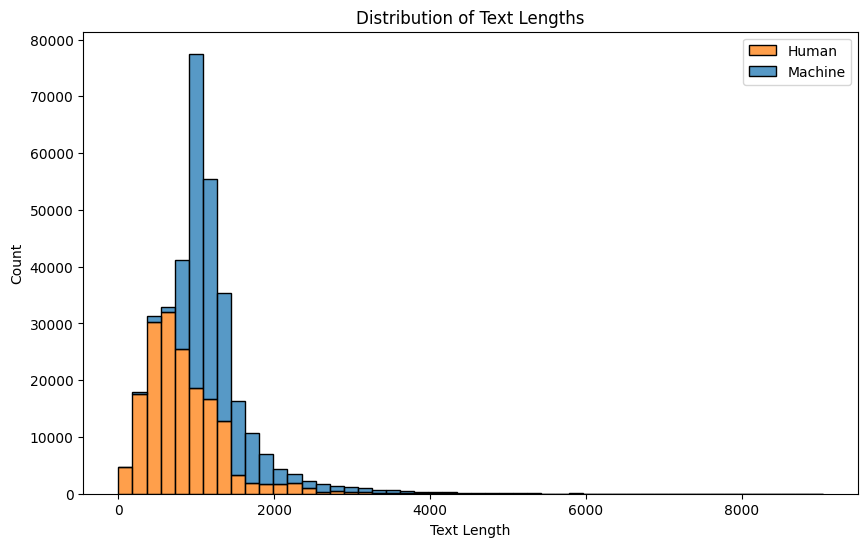


2. Text Length Statistics:
          count         mean         std    min    25%     50%     75%     max
label                                                                         
0      177508.0  1289.531092  548.375637  203.0  982.0  1131.0  1398.0  9042.0
1      171637.0   837.631303  516.368860    0.0  489.0   731.0  1087.0  4943.0


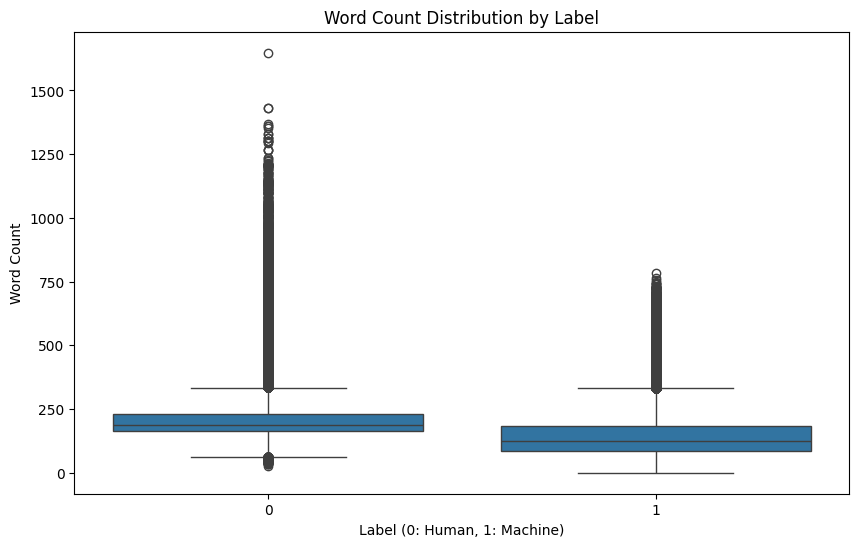


4. Top 20 words in human-written texts:
[('the', 2563295), ('of', 1283299), ('and', 1174492), ('in', 1103285), ('a', 912948), ('to', 826858), ('is', 508153), ('was', 439921), ('for', 339387), ('as', 320649), ('on', 287715), ('that', 271979), ('he', 265051), ('with', 262586), ('by', 259208), ('it', 254866), ('from', 206623), ('at', 205277), ('his', 176786), ('an', 170742)]

Top 20 words in machine-generated texts:
[('the', 1556262), ('and', 871892), ('of', 840574), ('in', 833116), ('a', 580889), ('to', 482270), ('is', 335488), ('was', 302277), ('for', 235026), ('he', 233458), ('as', 214128), ('on', 203941), ('by', 169597), ('with', 155852), ('that', 147094), ('it', 146646), ('from', 145180), ('his', 135789), ('at', 133886), ('has', 128047)]

5. Word Clouds:
Human-written texts:


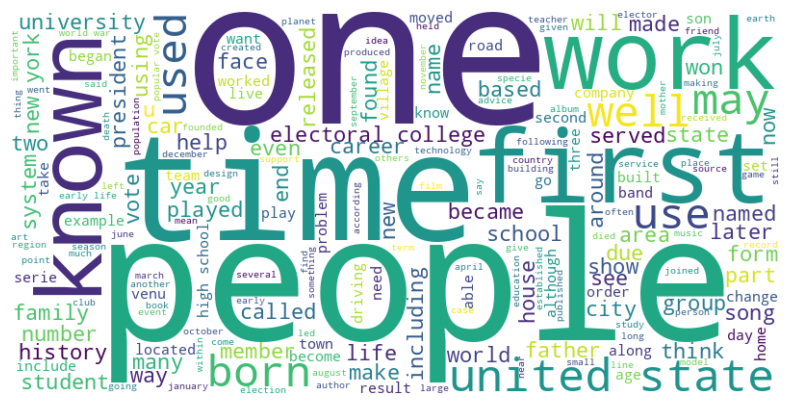

Machine-generated texts:


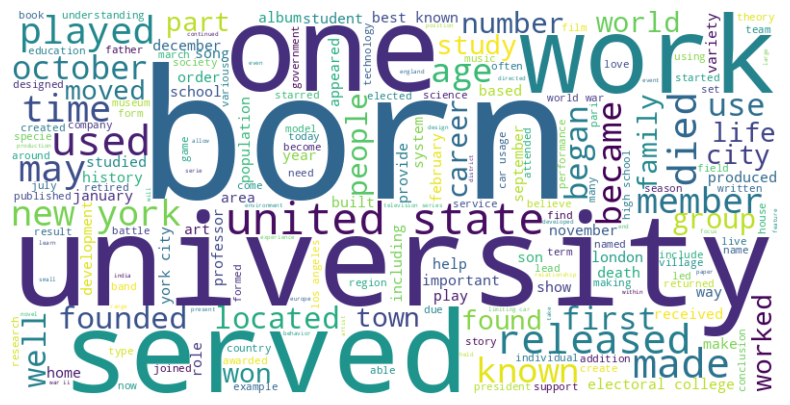

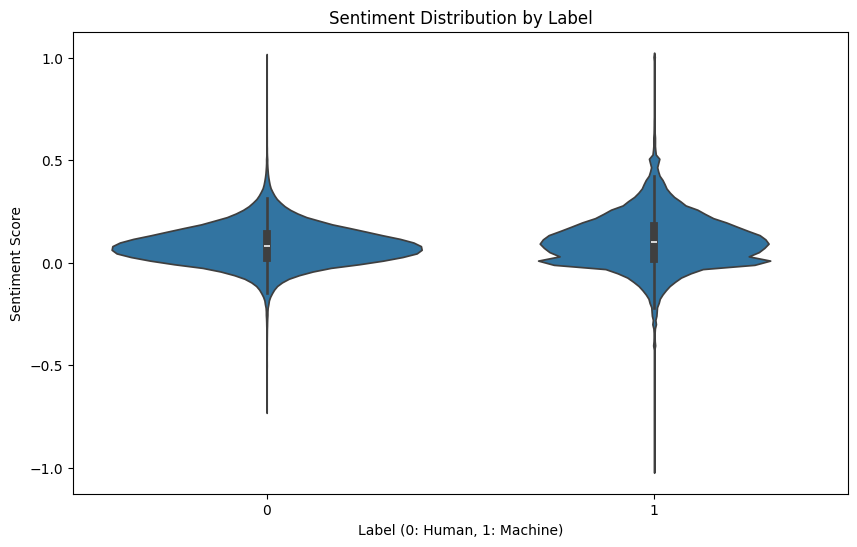


6. Sentiment Analysis:
          count      mean       std       min       25%       50%       75%  \
label                                                                         
0      177508.0  0.086062  0.095368 -0.714815  0.025167  0.080392  0.141667   
1      171637.0  0.106253  0.131293 -1.000000  0.018912  0.098869  0.179984   

       max  
label       
0      1.0  
1      1.0  


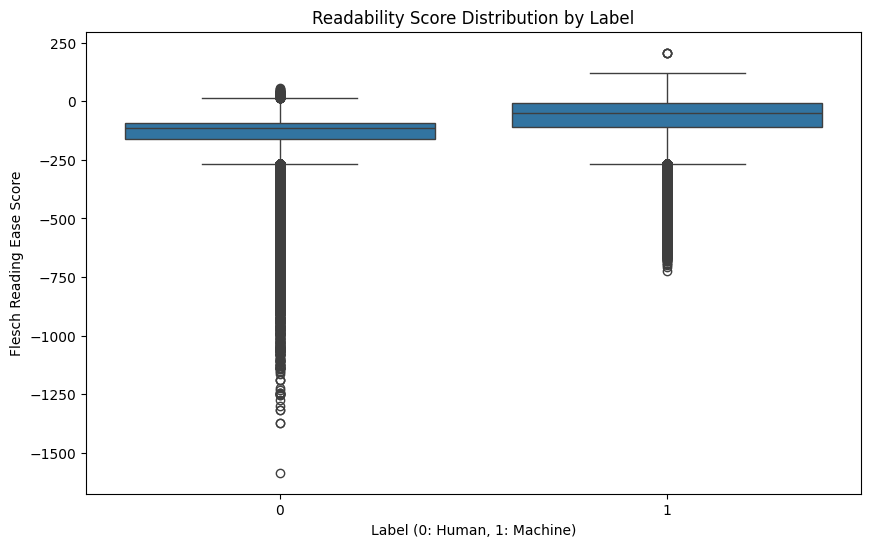


7. Readability Analysis:
          count        mean        std      min    25%     50%    75%     max
label                                                                        
0      177508.0 -144.728742  99.423450 -1584.33 -161.3 -116.31 -90.93   56.60
1      171637.0  -65.977870  86.449357  -725.31 -110.9  -49.99  -6.68  206.84

Distribution of content types:
Sports and Media: 202844
Academia and Biographies: 107121
Music and Entertainment: 35000
General Knowledge: 4180

Distribution of grouped content types:
Entertainment: 237844
Academic: 111301


In [ ]:
if __name__ == "__main__":

    #Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    #Load and preprocess data
    df_combined = load_data()
    df_combined['text'] = df_combined['text'].apply(preprocess_text)
    df_combined = df_combined.dropna()

    #Perform EDA
    perform_eda(df_combined)

    #Cluster content types
    all_texts = df_combined['text'].tolist()
    content_types, grouped_content_types = cluster_content_types(all_texts)
    analyze_content_distribution(content_types, grouped_content_types)

In [ ]:
# Data splitting and preprocessing
# First, split off the test set
train_val_texts, test_texts, train_val_labels, test_labels = train_test_split(df_combined['text'], df_combined['label'], test_size=0.2, random_state=42)

# Then split the remaining data into train and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(train_val_texts, train_val_labels, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2 of original data

# Clean the data
train_texts, train_labels = clean_data(train_texts, train_labels)
val_texts, val_labels = clean_data(val_texts, val_labels)
test_texts, test_labels = clean_data(test_texts, test_labels)

In [ ]:
# Initialize tokenizer and process data
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
train_input_ids, train_attention_masks, train_advanced_features, train_labels = process_in_batches(train_texts, train_labels, tokenizer, device=device)
val_input_ids, val_attention_masks, val_advanced_features, val_labels = process_in_batches(val_texts, val_labels, tokenizer, device=device)
test_input_ids, test_attention_masks, test_advanced_features, test_labels = process_in_batches(test_texts, test_labels, tokenizer, device=device)

In [ ]:
def save_processed_data(filename, input_ids, attention_masks, advanced_features, labels):
    torch.save({
        'input_ids': input_ids,
        'attention_masks': attention_masks,
        'advanced_features': advanced_features,
        'labels': labels
    }, filename)

#saving processed data
save_processed_data('train_processed.pt', train_input_ids, train_attention_masks, train_advanced_features, train_labels)
save_processed_data('val_processed.pt', val_input_ids, val_attention_masks, val_advanced_features, val_labels)
save_processed_data('test_processed.pt', test_input_ids, test_attention_masks, test_advanced_features, test_labels)

In [ ]:
def load_processed_data(filename):
    data = torch.load(filename)
    return data['input_ids'], data['attention_masks'], data['advanced_features'], data['labels']

#load processed data
train_input_ids, train_attention_masks, train_advanced_features, train_labels = load_processed_data('/content/drive/My Drive/train_processed.pt')
val_input_ids, val_attention_masks, val_advanced_features, val_labels = load_processed_data('/content/drive/My Drive/val_processed.pt')
test_input_ids, test_attention_masks, test_advanced_features, test_labels = load_processed_data('/content/drive/My Drive/test_processed.pt')

In [ ]:
#Feature Normalization and Dataset Creation
#Normalize features
scaler = StandardScaler()
train_advanced_features = scaler.fit_transform(train_advanced_features)
val_advanced_features = scaler.transform(val_advanced_features)
test_advanced_features = scaler.transform(test_advanced_features)

#Create datasets and dataloaders
train_dataset = TensorDataset(train_input_ids, train_attention_masks, torch.tensor(train_advanced_features), train_labels)
val_dataset = TensorDataset(val_input_ids, val_attention_masks, torch.tensor(val_advanced_features), val_labels)
test_dataset = TensorDataset(test_input_ids, test_attention_masks, torch.tensor(test_advanced_features), test_labels)

batch_size = 32
train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=batch_size)
val_dataloader = DataLoader(val_dataset, sampler=SequentialSampler(val_dataset), batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, sampler=SequentialSampler(test_dataset), batch_size=batch_size)

In [ ]:
#Model Initialization and Training Setup

#Determine the number of linguistic features
num_linguistic_features = train_advanced_features.shape[1]  # Assuming train_advanced_features is your feature tensor
# Initialize model
bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
model = CustomBERTModel(bert_model.bert, num_linguistic_features)
model.to(device)


#Training setup
optimizer = AdamW(model.parameters(), lr=5e-5, eps=1e-8, weight_decay=0.01)
epochs = 3
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

#Initialize continuous learning dataset
continuous_dataset = ContinuousLearningDataset(tokenizer, scaler, device=device)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
#Converting model to float
model = model.float()

#Training Loop
best_val_f1 = 0
patience = 3
no_improve_epochs = 0

for epoch in range(epochs):
    print(f"\nEpoch {epoch + 1}/{epochs}")

    start_time = time.time()
    avg_train_loss = train_epoch(model, train_dataloader, optimizer, scheduler, device)
    end_time = time.time()
    print(f"Training time: {end_time - start_time:.2f} seconds")

    val_accuracy, val_precision, val_recall, val_f1, val_conf_matrix = evaluate(model, val_dataloader, device)
    print(f"Validation Accuracy: {val_accuracy:.4f}, Precision: {val_precision:.4f}, "
          f"Recall: {val_recall:.4f}, F1-score: {val_f1:.4f}")
    print("Confusion Matrix:")
    print(val_conf_matrix)

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        no_improve_epochs = 0
        torch.save(model.state_dict(), 'best_model.pth')
        print("New best model saved!")
    else:
        no_improve_epochs += 1

    if no_improve_epochs >= patience:
        print("Early stopping triggered")
        break

    #Continuous learning phase
    if epoch > 0:
        print("\nContinuous learning phase:")
        new_texts = train_texts[:1000]
        new_labels = train_labels[:1000]

        continuous_dataset.add_examples(new_texts, new_labels)
        continuous_dataloader = DataLoader(continuous_dataset, batch_size=32, shuffle=True)

        cl_start_time = time.time()
        avg_cl_loss = train_epoch(model, continuous_dataloader, optimizer, scheduler, device)
        cl_end_time = time.time()
        print(f"Continuous learning time: {cl_end_time - cl_start_time:.2f} seconds")
        print(f"Continuous learning loss: {avg_cl_loss:.4f}")

    print(f"Epoch {epoch + 1} completed")

In [ ]:
#Load the saved model
model.load_state_dict(torch.load('best_model.pth'))
model.to(device)

#Avoiding retraining drom first epoch to save time
start_epoch = 2
for epoch in range(start_epoch, epochs + 1):
    print(f"\nEpoch {epoch}/{epochs}")

    start_time = time.time()
    avg_train_loss = train_epoch(model, train_dataloader, optimizer, scheduler, device)
    end_time = time.time()
    print(f"Training time: {end_time - start_time:.2f} seconds")

    val_accuracy, val_precision, val_recall, val_f1, val_conf_matrix = evaluate(model, val_dataloader, device)
    print(f"Validation Accuracy: {val_accuracy:.4f}, Precision: {val_precision:.4f}, "
          f"Recall: {val_recall:.4f}, F1-score: {val_f1:.4f}")
    print(f"Confusion Matrix:\n{val_conf_matrix}")

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        no_improve_epochs = 0
        torch.save(model.state_dict(), 'best_model.pth')
        print("New best model saved!")
    else:
        no_improve_epochs += 1

    if no_improve_epochs >= patience:
        print("Early stopping triggered")
        break

    print(f"Epoch {epoch} completed")

    #Continuous learning phase
    if epoch > 0:
        print("\nContinuous learning phase:")
        new_texts = train_texts[:1000]
        new_labels = train_labels[:1000]

        continuous_dataset.add_examples(new_texts, new_labels)
        continuous_dataloader = DataLoader(continuous_dataset, batch_size=32, shuffle=True)

        cl_start_time = time.time()
        avg_cl_loss = train_epoch(model, continuous_dataloader, optimizer, scheduler, device)
        cl_end_time = time.time()
        print(f"Continuous learning time: {cl_end_time - cl_start_time:.2f} seconds")
        print(f"Continuous learning loss: {avg_cl_loss:.4f}")

    print(f"Epoch {epoch + 1} completed")


Epoch 2/3


Training: 100%|██████████| 6547/6547 [16:07<00:00,  6.77it/s, Loss=0.0000]


Training time: 967.68 seconds


Evaluating: 100%|██████████| 2182/2182 [01:44<00:00, 20.84it/s]


Validation Accuracy: 0.9826, Precision: 0.9831, Recall: 0.9826, F1-score: 0.9826
Confusion Matrix:
[[34162  1192]
 [   23 34443]]
New best model saved!
Epoch 2 completed

Continuous learning phase:


Training: 100%|██████████| 95/95 [00:14<00:00,  6.77it/s, Loss=0.0000]


Continuous learning time: 14.04 seconds
Continuous learning loss: 0.0000
Epoch 3 completed

Epoch 3/3


Training: 100%|██████████| 6547/6547 [16:08<00:00,  6.76it/s, Loss=0.0000]


Training time: 968.03 seconds


Evaluating: 100%|██████████| 2182/2182 [01:44<00:00, 20.87it/s]


Validation Accuracy: 0.9910, Precision: 0.9911, Recall: 0.9910, F1-score: 0.9910
Confusion Matrix:
[[34775   579]
 [   48 34418]]
New best model saved!
Epoch 3 completed

Continuous learning phase:


Training: 100%|██████████| 127/127 [00:18<00:00,  6.79it/s, Loss=0.0000]

Continuous learning time: 18.72 seconds
Continuous learning loss: 0.0000
Epoch 4 completed


In [ ]:
#Load best model
model.load_state_dict(torch.load('best_model.pth'))

#Evaluate on the test set
test_accuracy, test_precision, test_recall, test_f1, test_confusion_matrix = evaluate(model, test_dataloader, device)
print(f"Test Accuracy: {test_accuracy:.4f}, Precision: {test_precision:.4f}, "
      f"Recall: {test_recall:.4f}, F1-score: {test_f1:.4f}")
print("Confusion Matrix:")
print(test_confusion_matrix)

Evaluating: 100%|██████████| 2183/2183 [01:44<00:00, 20.90it/s]


Test Accuracy: 0.9949, Precision: 0.9949, Recall: 0.9949, F1-score: 0.9949
Confusion Matrix:
[[35414   176]
 [  179 34058]]


In [117]:
# Analyze patterns across content types
model.load_state_dict(torch.load('best_model.pth'))
model.to(device)
test_content_types = [content_types[i] for i in range(len(test_texts))]
analyze_patterns(model, test_dataloader, test_content_types, device)

print("\nTraining and analysis complete.")

Analyzing patterns: 100%|██████████| 2183/2183 [01:44<00:00, 20.89it/s]



Metrics for Sports and Media:
Accuracy: 0.9910
Precision: 0.9911
Recall: 0.9910
F1-score: 0.9910

Metrics for Academia and Biographies:
Accuracy: 0.9900
Precision: 0.9901
Recall: 0.9900
F1-score: 0.9900

Metrics for General Knowledge:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-score: 1.0000

Metrics for Music and Entertainment:
Accuracy: 0.9891
Precision: 0.9893
Recall: 0.9891
F1-score: 0.9891

Training and analysis complete.


Performing comprehensive analysis...
Sample 1:
Input text: the inmate spanish el recluso is an american television series produced by telemundo internacional studios that premiered on telemundo on 25 september 2018 and concluded on 11 october 2018 it is an adaptation of the argentine television series titled el marginal created by sebastian ortega and adrian caetano the series tells the story of an exmarine who enters a maximum security prison on the border between mexico and the united states to investigate the kidnapping of the daughter of a prominent us judge plot an american exmarine lazaro mendoza ignacio serricchio enters a maximum security prison in mexico la rotunda under a false identity and accused of an alleged triple
True label: Human-written
Predicted label: Human-written


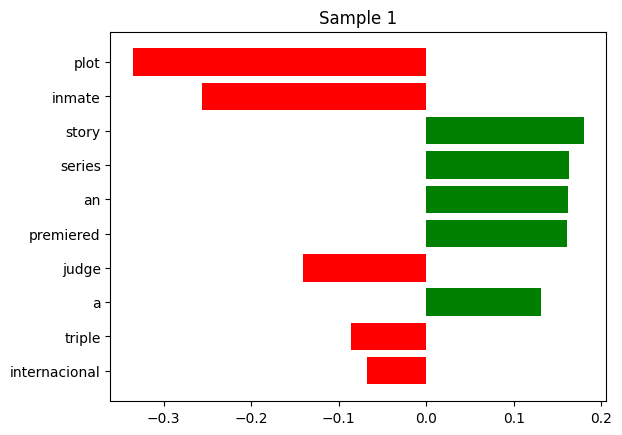



Sample 2:
Input text: scrobipalpa parvipulex is a moth in the family gelechiidae it was described by walsingham in 1911 it is found in algeria the wingspan is the forewings are creamy white specked and spotted with dark umberbrown there is a group of three spots forming a triangle at the base two at half the wingwidth and a third forming the apex on the costa at about onefourth an oblique streak apparently composed of two or more dark spots descends obliquely outward from the costa reaching to the fold scarcely separated from its outer edge is another spot on the disc before the middle and remote
True label: Human-written
Predicted label: Human-written


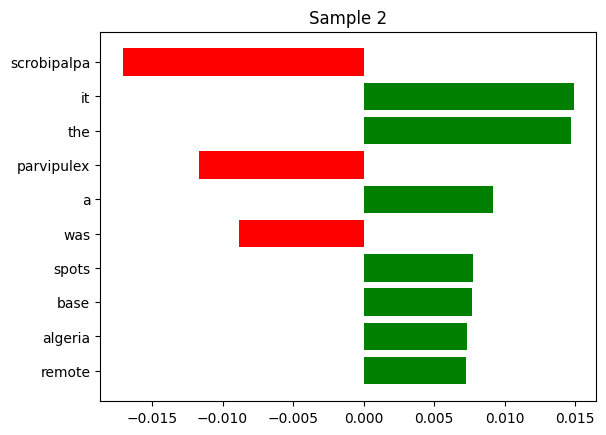



Sample 3:
Input text: prominent landmarks in delhi india the gate was built in the late 18th century by mughal emperor shah jahan as a means of preventing the entry of robbers and thieves into the city the gate is located in the walled city of old delhi near the jahanpanah temple ganja gate is a significant historical landmark located in the walled city of old delhi near the jahanpanah temple the gate was built in the late 18th century by mughal emperor shah jahan as a means of preventing the entry of robbers and thieves into the city the gate is located in the walled city of old delhi near the jahanpanah temple the gate is made
True label: Machine-generated
Predicted label: Machine-generated


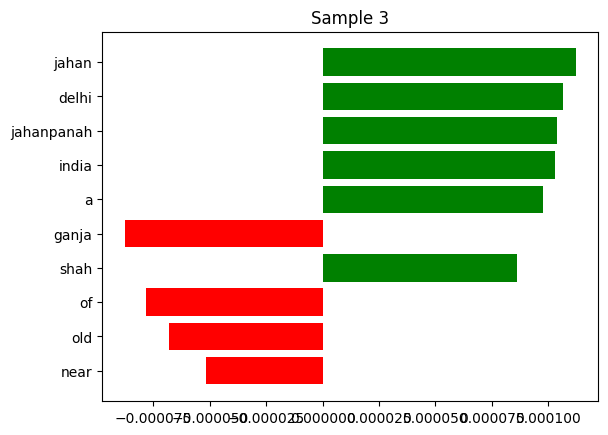



Sample 4:
Input text: imagining a day without a car seems impossible if you are one of those people who depend on a car seven days a week if you my fellow citizens take the chance to live at least a day without a car you would experience all the advantages of not having a vehicle these advantages include saving money time and the enviroment not only will you be saving things we all wish to save on we will also gain the oppurtunity to have more one on one time with friends or even family experiencing a day without something you always depend on may seem foolish considering passenger cars are responsible for 12 percent of greenhouse gas emissions in europeand up
True label: Human-written
Predicted label: Human-written


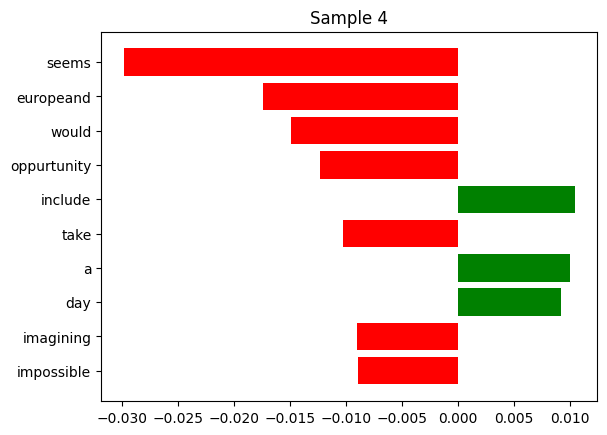



Sample 5:
Input text: the role of technology in education has been a hot topic in recent years with its potential for both good and bad being debated on one hand access to technology can provide students with more opportunities to learn than ever before bridging the gaps between learning styles that have traditionally been difficult on the other hand it can be seen as a distraction from traditional classroombased learning by introducing too many sources of information or complex tools that may not always be appropriate for younger learners ultimately technology must be used responsibly within an educational setting if it is to benefit students and teachers alike when used correctly technology can make a huge difference in how we approach teaching
True label: Machine-generated
Predicted label: Machine-generated


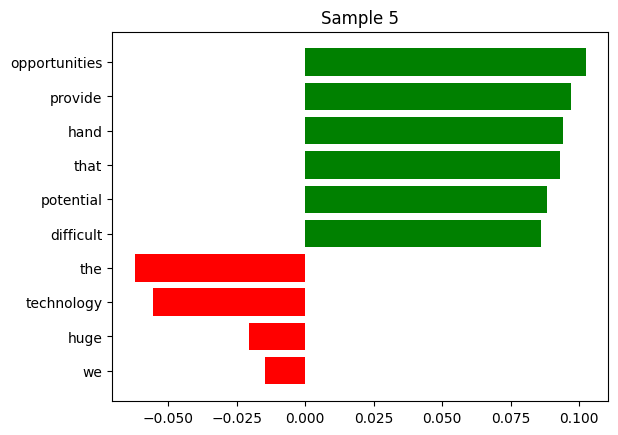

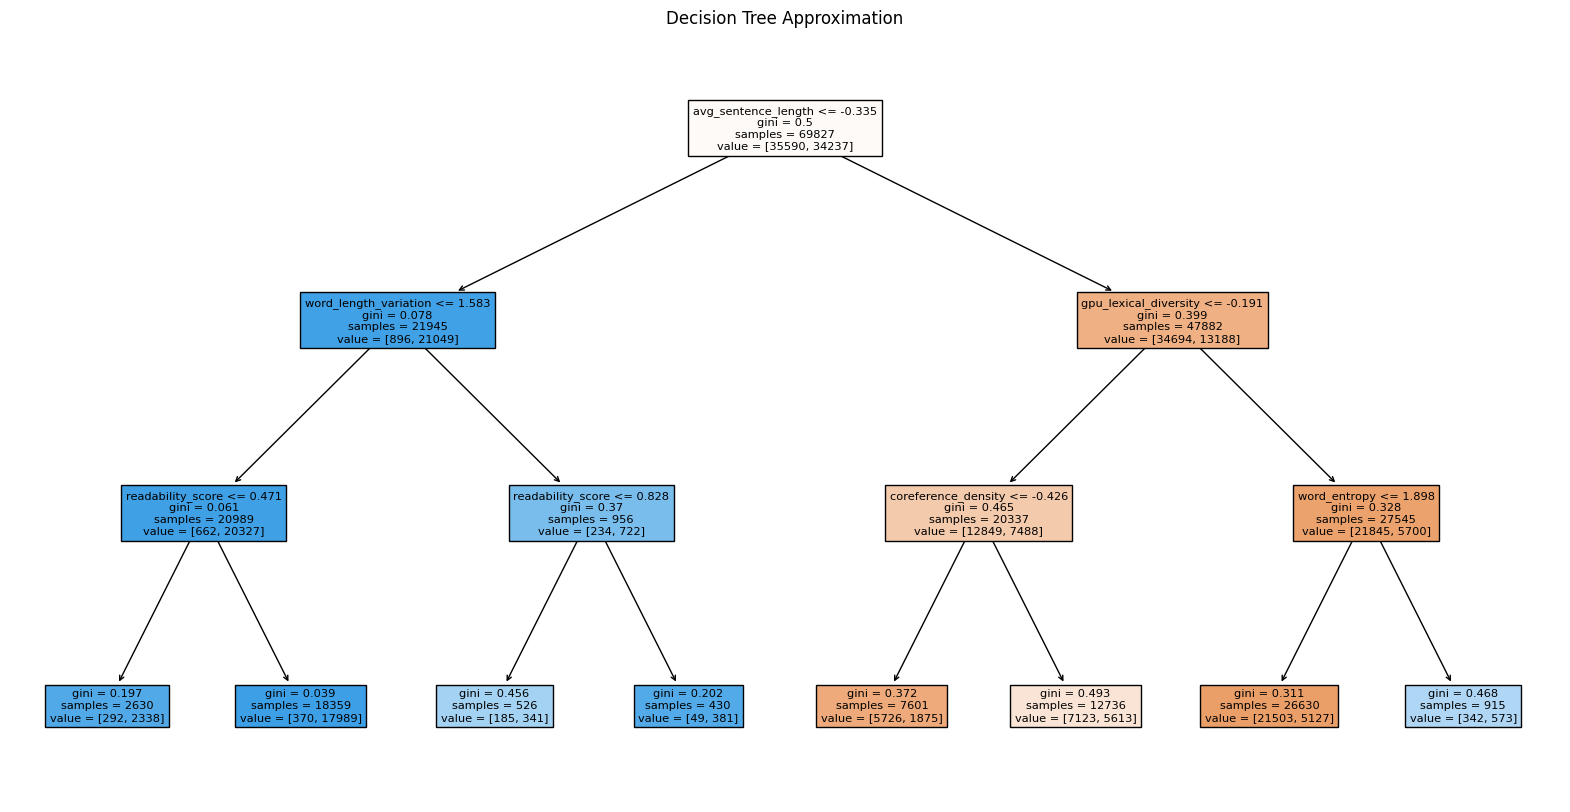


Feature Importances:
                      Feature  Importance
0         avg_sentence_length    0.906713
22      gpu_lexical_diversity    0.039212
17        coreference_density    0.023100
13               word_entropy    0.021445
3       word_length_variation    0.005358
7           readability_score    0.004172
1   sentence_length_variation    0.000000
6           conjunction_ratio    0.000000
5               pronoun_ratio    0.000000
4           lexical_diversity    0.000000
2             avg_word_length    0.000000
10                 verb_ratio    0.000000
11            adjective_ratio    0.000000
9                  noun_ratio    0.000000
8            complexity_score    0.000000
14    avg_dependency_distance    0.000000
12               adverb_ratio    0.000000
16                num_clauses    0.000000
15                 tree_depth    0.000000
18         sentiment_polarity    0.000000
19     sentiment_subjectivity    0.000000
20             sentence_count    0.000000
21          

In [120]:
print("Performing comprehensive analysis...")
#content_types = [content_types[i] for i in range(len(val_texts))]
interpret_model(model, tokenizer, device, test_dataset, feature_names, num_samples=5)